In [1]:
import mne 
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
figure(figsize=(1,1))
from mne.decoding import UnsupervisedSpatialFilter
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from mne.decoding import (Vectorizer,SlidingEstimator,
                          cross_val_multiscore, LinearModel, 
                          get_coef)

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import itertools
from sklearn.svm import SVC 

from scipy.stats import skew, kurtosis

In [2]:
def arrayFiles(path):
    folderContent = os.listdir(path)
    fifFiles = []
    for i in folderContent :
        fifFiles.append(path + "/" + i)
    
    return fifFiles

In [3]:
path = '/Volumes/flash64/EpochedEEG'
allFifFiles = arrayFiles(path)

In [4]:
epoch = mne.read_epochs(allFifFiles[0],preload=True)

Reading /Volumes/flash64/EpochedEEG/20131216_1441_epo.fif ...
    Found the data of interest:
        t =    -199.22 ...     500.00 ms
        0 CTF compensation matrices available
5424 matching events found
Applying baseline correction (mode: mean)
5424 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [5]:
new_stim_code_event_ids = {
     
    "b-f2-wrd":1,
    "b-f1-wrd":2,
    "b-tg-wrd":3,

    "b-f2-spk":4,
    "b-f1-spk":5,
    "b-tg-spk":6,

    "b-f2-pic":7,
    "b-f1-pic":8,
    "b-tg-pic":9,

    "b-f2-snd":10,
    "b-f1-snd":11,
    "b-tg-snd":12,

    "f-f2-wrd":13,
    "f-f1-wrd":14,
    "f-tg-wrd":15,

    "f-f2-spk":16,
    "f-f1-spk":17,
    "f-tg-spk":18,

    "f-f2-pic":19,
    "f-f1-pic":20,
    "f-tg-pic":21,

    "f-f2-snd":22,
    "f-f1-snd":23,
    "f-tg-snd":24
}

In [6]:
def update_stim_code(epoch):
    keys_to_delete = [x for x in epoch.event_id if 'stim' in x]
    for key in keys_to_delete:
        if 'stim' in key:
            del epoch.event_id[key]
            
    for key in new_stim_code_event_ids:
        epoch.event_id[key] = new_stim_code_event_ids[key]
    
    return epoch

In [7]:
epoch

<EpochsFIF  |   5424 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~961.2 MB, data loaded,
 'congruent': 320
 'correct': 231
 'f_baby': 68
 'f_bell': 48
 'f_bird': 48
 'f_burp': 28
 'f_dog': 64
 'f_drum': 60
 'f_knock': 56
 'f_laugh': 96
 'f_phone': 84
 'f_train': 56
 'f_water': 32
 'flanker_stim_1': 100
 'flanker_stim_10': 80
 'flanker_stim_11': 80
 'flanker_stim_12': 60
 'flanker_stim_2': 100
 'flanker_stim_3': 100
 'flanker_stim_4': 61
 'flanker_stim_5': 60
 'flanker_stim_6': 60
 'flanker_stim_7': 100
 'flanker_stim_8': 100
 'flanker_stim_9': 120
 'incongruent': 320
 'incorrect': 37
 'left_button': 334
 'right_button': 342
 't_baby': 60
 't_bell': 50
 't_bird': 50
 't_burp': 60
 't_dog': 60
 't_drum': 50
 't_knock': 60
 't_laugh': 70
 't_phone': 60
 't_train': 70
 't_water': 50
 'target_stim_13': 59
 'target_stim_14': 60
 'target_stim_15': 100
 'target_stim_16': 80
 'target_stim_17': 80
 'target_stim_18': 80
 'target_stim_19': 100
 'target_stim_20': 100
 'target_s

In [8]:
epochWnewStim = update_stim_code(epoch)
epochWnewStim.events.shape

(5424, 3)

In [9]:
events = epochWnewStim.events[:,-1]
event_ids = epochWnewStim.event_id

In [10]:
stim_combinations = {
    (5,6,4): "AALL",
    (17,18,16) :"AALL",
    
    (11,6,10):"AALN",
    (23,18,22):"AALN",
    
    (5,12,4) :"AANL",
    (17,24,16):"AANL",
    
    (11,12,10) : "AANN",
    (23,24,22): "AANN",
    
    (2,6,1):"AVLL",
    (14,18,13):"AVLL",
    
    (8,12,7):"AVNN",
    (20,24,19):"AVNN",
    
    (5,3,4) :"VALL",
    (17,15,16):"VALL",
    
    (11,9,10) :"VANN",
    (23,21,22):"VANN",
    
    (2,3,1) :"VVLL",
    (14,15,13):"VVLL",
    
    (8,3,7):"VVLN",
    (20,15,19):"VVLN",
    
    (2,9,1) :"VVNL",
    (14,21,13):"VVNL",
    
    (8,9,7) :"VVNN",
    (20,21,19):"VVNN",
    
    (14,21,4):"whatever"
    
    
    
}

In [11]:
events = epochWnewStim.events
events_new = []
temp = []
combo = []


for event in events:
    if event[-1] == 31:
        combo = []
        for trialEpochs in temp:
            if trialEpochs[-1] >=1 and trialEpochs[-1]<=24:
                combo.append(trialEpochs[-1])
        if len(combo) == 3: 
            combo_tuple = (combo[0],combo[1],combo[2]) 
            if stim_combinations[combo_tuple] == "VVNN" :
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 100
            elif stim_combinations[combo_tuple] == "AANN":
                #print(combo_tuple)
                for k in temp:
                    if k[-1] >= 1 and k[-1] <= 24:
                        #print(k)
                        k[-1] = 200       
            combo_tuple = []
                
        
        for p in temp:
            if p[-1] == 100 or p[-1] == 200:
                events_new.append(p)
#             if p[-1] >=1 and p[-1] <=24:
#                 events_new.append(p)
        temp = []
        temp.append(event)
    else:
        temp.append(event)
events_new

[array([27806,     0,   100]),
 array([27931,     0,   100]),
 array([28060,     0,   100]),
 array([28521,     0,   100]),
 array([28646,     0,   100]),
 array([28775,     0,   100]),
 array([29292,     0,   100]),
 array([29417,     0,   100]),
 array([29546,     0,   100]),
 array([29826,     0,   100]),
 array([29951,     0,   100]),
 array([30080,     0,   100]),
 array([30752,     0,   100]),
 array([30876,     0,   100]),
 array([31006,     0,   100]),
 array([31406,     0,   100]),
 array([31531,     0,   100]),
 array([31660,     0,   100]),
 array([31940,     0,   100]),
 array([32065,     0,   100]),
 array([32194,     0,   100]),
 array([32646,     0,   100]),
 array([32771,     0,   100]),
 array([32900,     0,   100]),
 array([33383,     0,   100]),
 array([33508,     0,   100]),
 array([33637,     0,   100]),
 array([35463,     0,   100]),
 array([35587,     0,   100]),
 array([35717,     0,   100]),
 array([36328,     0,   100]),
 array([36453,     0,   100]),
 array([

In [12]:
#New epoch with only visual stim code combinations
test = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [13]:
#checking if test is an epoch.
type(test)

mne.epochs.EpochsFIF

In [14]:
#shape of original epoch
epochWnewStim.get_data().shape

(5424, 129, 180)

In [15]:
type(epochWnewStim)

mne.epochs.EpochsFIF

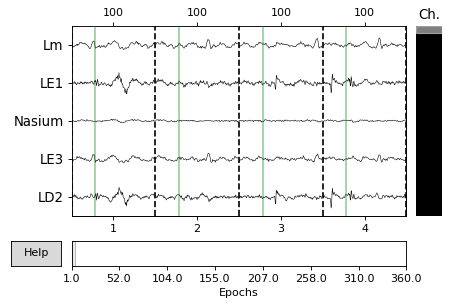

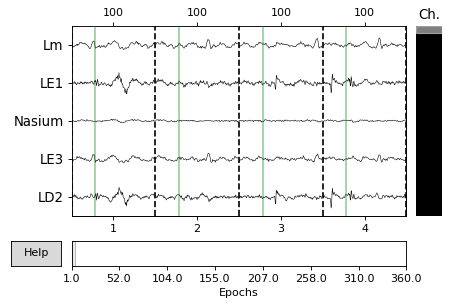

In [16]:
#360 x 129 x 180 epoch
test.plot(n_channels=5,n_epochs=4)

In [17]:
test.get_data().shape

(360, 129, 180)

In [18]:
from sklearn.cross_validation import train_test_split

#set features as epoch data
#set targets as event ids
features_data = test.get_data()
target_V_vs_A = test.events[:,-1]

print("shape of data",features_data.shape)
print("shape of target array",target_V_vs_A.shape)




shape of data (360, 129, 180)
shape of target array (360,)


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [19]:
#pipeling for converting data from 3D to 2D using vectorizer and
#LogisticRegression for classification
clf = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    (LogisticRegression(C=1)))

#Provides train/test indices to split data in train/test sets.
cv = StratifiedKFold(n_splits = 10, shuffle=True)
#y_preds = np.empty(len(target_V_vs_A))
score = []
# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

#i = 0
for train,test in cv.split(features_data,target_V_vs_A):
    X_train = features_data[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = features_data[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    #fit the model to training set
    clf.fit(X_train,y_train)
    
    #returns the mean accuracy on test data and labels
    score.append(clf.score(X_test,y_test))
    
    
    




In [20]:
print("mean classification score", np.mean(score))

mean classification score 0.763888888888889


In [21]:
#new epoch with only events corresponding to 100 or 200(visual/audio stim codes)
binaryEpoch = epochWnewStim[(epochWnewStim.events[:,-1]==100) | (epochWnewStim.events[:,-1]==200)].copy()

In [22]:
type(binaryEpoch)

mne.epochs.EpochsFIF

In [23]:
binaryEpoch

<EpochsFIF  |   360 events (all good), -0.199219 - 0.5 sec, baseline [-0.199219, 0], ~64.1 MB, data loaded>

In [24]:
#get the coeficients after fitting clf to training sets
patterns2 = get_coef(clf,'coef_')
#print(patterns2)

#convert patterns2 to 129 x 180 array from 1 x 23220
#take each block of 180 coeficients and put them together 
#for each channel. We will have 129 channels rows with
#180 time columns
hold = []
for h in range(0,23219,180):
    temp = []
    for i in range(h,h+180):
        temp.append(patterns2[0][i])
    hold.append(temp)     
npHold = np.array(hold)
npHold.shape

(129, 180)

In [63]:
patterns2.shape

(1, 23220)

In [54]:
dataF = pd.DataFrame(npHold)
dataF

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.023300,-0.025109,0.027152,0.009618,-0.044307,0.002128,0.040688,-0.009737,-0.025042,-0.000519,...,-0.020020,-0.003501,0.008687,0.055031,0.008757,-0.050185,0.010125,0.023550,-0.019766,-0.019897
1,-0.000785,0.019480,0.009367,0.001807,0.002927,-0.019273,-0.032449,-0.003979,0.000025,-0.007972,...,-0.000095,0.005113,-0.027132,-0.019734,-0.002421,0.002215,-0.000419,-0.003760,-0.006851,-0.004696
2,0.018352,0.027874,0.059072,0.060425,0.064905,0.017233,0.030089,0.007997,-0.004379,0.033970,...,0.006988,-0.030207,-0.029048,-0.022091,-0.010841,0.003832,-0.003792,-0.001993,0.015151,0.000963
3,0.064738,0.016193,0.011839,0.046689,-0.028615,0.038733,0.059952,-0.082676,-0.030999,-0.023590,...,-0.017622,-0.004027,0.007036,0.051347,0.014885,-0.032916,0.001977,0.020799,-0.002940,-0.031640
4,0.000369,0.009218,-0.003526,0.011411,-0.000099,-0.018538,-0.019258,0.010099,0.012427,-0.011141,...,0.012495,0.003420,-0.066113,-0.016792,0.014459,0.003367,0.005252,-0.010643,-0.008280,0.006684
5,0.000195,-0.003191,-0.004555,0.038444,-0.020520,-0.031771,-0.073914,-0.031319,0.000651,0.004649,...,0.004667,0.030052,-0.027507,-0.028784,0.002609,0.009744,-0.007562,-0.001100,0.001481,-0.031493
6,-0.002150,0.004576,0.003908,-0.001081,-0.008932,-0.030881,-0.040486,0.014327,0.016014,0.006469,...,-0.010300,-0.008405,-0.013374,0.000308,0.007866,-0.004633,-0.005555,-0.005569,0.003639,0.041212
7,0.015974,0.028145,0.027967,0.001868,0.012014,0.015678,0.032490,0.029854,0.004526,0.024425,...,-0.007181,-0.024743,-0.025964,-0.028074,-0.002324,0.001938,0.008524,0.011085,0.023407,0.017124
8,0.017843,0.015171,0.009518,-0.000785,-0.009878,-0.052041,-0.054064,-0.015918,-0.034399,-0.037883,...,-0.033840,-0.006895,-0.000330,-0.009068,-0.008743,-0.001420,0.001561,-0.004635,0.017171,-0.003312
9,0.000201,0.011273,0.018546,0.036413,0.002935,-0.000462,0.012226,0.010862,0.001557,0.032552,...,-0.012370,-0.017956,-0.016982,-0.019417,-0.004907,-0.019545,-0.006842,-0.003838,-0.006283,0.001097


     channel  variance      skew   kurtosis
0        0.0  0.017250 -0.960754   4.589836
1        1.0  0.029273 -0.325430   3.829752
2        2.0 -0.017825 -0.906045   5.845291
3        3.0  0.025050 -0.611111   1.190626
4        4.0  0.019907  0.285351   1.866023
5        5.0  0.039555 -0.684283   8.074627
6        6.0 -0.016365 -1.188344   7.202621
7        7.0 -0.026750 -1.769926   8.141631
8        8.0  0.015712  0.517479   3.921798
9        9.0 -0.026918 -0.165098   3.581599
10      10.0  0.008112  0.625588   4.589656
11      11.0 -0.019360  0.198000   7.006785
12      12.0  0.029453  0.528486   1.198198
13      13.0 -0.004940  0.687460   3.368450
14      14.0 -0.028588 -0.016064   1.541153
15      15.0 -0.030255 -1.079623   4.627559
16      16.0  0.005662 -0.430160   0.524722
17      17.0 -0.025223  0.439862   1.642562
18      18.0 -0.001248  0.699399   3.272889
19      19.0  0.000243 -0.059971   1.314206
20      20.0  0.006996 -0.397806   0.292775
21      21.0 -0.003653  0.271341

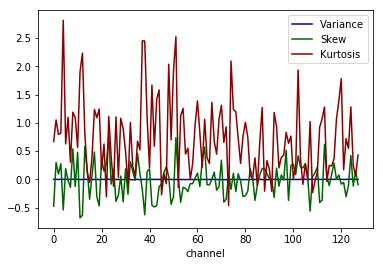

In [64]:
import scipy
import pandas as pd
#Simplify coef data by reducing 180 columns to 3
arr1 = []
for i in range(0,128):
    temp1 = []
    var1 = np.mean(npHold[i])
    skew1 = scipy.stats.skew(npHold[i])
    kurtosis1 = scipy.stats.kurtosis(npHold[i])
    temp1.append(i)
    temp1.append(var1)
    temp1.append(skew1)
    temp1.append(kurtosis1)
    arr1.append(temp1)

w1 = np.array(arr1)   
dfff = pd.DataFrame(w1)  
print(df)

#plot the matrix
dfff.columns = ['channel','variance','skew','kurtosis']
ax = dfff.plot.line(x='channel',y='variance',color='DarkBlue',label='Variance')
dfff.plot.line(x='channel',y='skew',color='DarkGreen',label="Skew",ax=ax)
dfff.plot.line(x='channel',y='kurtosis',color="DarkRed",label="Kurtosis",ax=ax)


In [26]:
dfff

,channel,variance,skew,kurtosis
0,0.0,-0.000022,-0.474279,0.670203
1,1.0,0.001694,0.299677,1.051317
2,2.0,-0.000946,0.096046,0.794263
3,3.0,0.002810,0.276180,0.817613
4,4.0,0.000960,-0.539714,2.813266
5,5.0,0.003124,0.190204,0.628874
6,6.0,0.001165,-0.015761,1.098824
7,7.0,-0.001398,-0.138398,0.304859
8,8.0,0.003091,0.538728,1.188595
9,9.0,0.000063,-0.123062,1.091169


In [27]:
dfff.idxmax(axis=0)

channel     127
variance    124
skew         23
kurtosis      4
dtype: int64

In [29]:
print ("Max Kurtosis for channel:",binaryEpoch.ch_names[4])

Max Kurtosis for channel: LD2


In [28]:
print ("Max skew for channel:",binaryEpoch.ch_names[23])

Max skew for channel: Z7


In [30]:
def get_mean_band(data):
    final_variances = []
    for d in data:
    #     print (data.shape)
        variances = []
        skewnesses = []
        kurtosises = []
        stats = []
        for channel in d:
    #         print(channel.shape)
            var = channel.var()
            variances.append(var)
            
            skewness = skew(channel, axis=0)
#             print(skewness)

            skewnesses.append(skewness)
#             print(skewness)
            kurt = kurtosis(channel)
            kurtosises.append(kurt)
#         print(skewnesses)
#         mean_skew = np.mean(skewnesses)
#         stats.append(mean_skew)
#         stats.append(np.mean(variances))
        final_variances.append([variances, skewnesses, kurtosises])
    
    return np.array(final_variances)

In [32]:
ReducePointsData = get_mean_band(binaryEpoch.get_data())


In [33]:
ReducePointsData.shape

(360, 3, 129)

In [48]:
binaryEpoch.get_data().shape

(360, 129, 180)

In [39]:
clf2 = make_pipeline(Vectorizer(),
                    MinMaxScaler(),
                    (LogisticRegression(C=1)))
score2 = []
for train,test in cv.split(ReducePointsData,target_V_vs_A):
    X_train = ReducePointsData[train] 
    #print("shape of training features(data):",X_train.shape)
    y_train = target_V_vs_A[train] 
    #print("shape of training target:",y_train.shape)
    X_test = ReducePointsData[test] 
    #print("shape of testing data:",X_test.shape)
    y_test = target_V_vs_A[test]
    #print("shape of testing target:",y_test.shape)
    
    #fit the model to training set
    clf2.fit(X_train,y_train)
    
    #returns the mean accuracy on test data and labels
    score2.append(clf.score(X_test,y_test))

In [40]:
print("mean classification score", np.mean(score2))

mean classification score 0.9722222222222221


In [50]:
Vectorizer().fit_transform(ReducePointsData).shape

(360, 387)

In [53]:
#get the coeficients after fitting clf to training sets

patterns3 = get_coef(clf2,'coef_')
hold3 = []
for h in range(0,386,3):
    temp2 = []
    for i in range(h,h+3):
        temp2.append(patterns3[0][i])
    hold3.append(temp2)     
npHold2 = np.array(hold3)
npHold2.shape

(129, 3)

In [56]:
dataFrame2 = pd.DataFrame(npHold2)
dataFrame2

,0,1,2
0,-1.671731,-0.095364,-0.053138
1,-0.861516,-0.131413,0.031709
2,-0.282371,-0.310982,0.000171
3,-0.121056,-0.307367,-0.286589
4,-0.053658,-0.101862,-0.127801
5,-0.146801,1.584138,0.015441
6,-0.002990,0.184844,0.725730
7,-0.085828,-0.083505,-0.103472
8,-0.331181,1.047764,-0.177802
9,-0.106761,-0.068138,-0.486514


Sensor Space Decoding

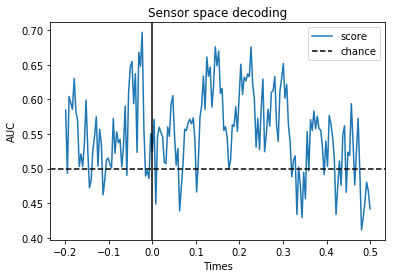

In [57]:
#decoding over time. We are using the last dimension in
#features_data (n_epochs x n_channels x n_times) to fit
#Linear model in each time instance and evaluate performance 
#on same instance for new epochs
clf2 = make_pipeline(StandardScaler(),LinearModel(LogisticRegression(C=1)))
time_decod = SlidingEstimator(clf2,n_jobs=1,scoring='roc_auc')

scores = cross_val_multiscore(time_decod,features_data,target_V_vs_A, cv =5, n_jobs=1)
scores = np.mean(scores, axis=0)
# Plot
fig, ax = plt.subplots()
ax.plot(binaryEpoch.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding')
plt.show()

In [68]:
binaryEpoch.times

array([-0.19921875, -0.1953125 , -0.19140625, -0.1875    , -0.18359375,
       -0.1796875 , -0.17578125, -0.171875  , -0.16796875, -0.1640625 ,
       -0.16015625, -0.15625   , -0.15234375, -0.1484375 , -0.14453125,
       -0.140625  , -0.13671875, -0.1328125 , -0.12890625, -0.125     ,
       -0.12109375, -0.1171875 , -0.11328125, -0.109375  , -0.10546875,
       -0.1015625 , -0.09765625, -0.09375   , -0.08984375, -0.0859375 ,
       -0.08203125, -0.078125  , -0.07421875, -0.0703125 , -0.06640625,
       -0.0625    , -0.05859375, -0.0546875 , -0.05078125, -0.046875  ,
       -0.04296875, -0.0390625 , -0.03515625, -0.03125   , -0.02734375,
       -0.0234375 , -0.01953125, -0.015625  , -0.01171875, -0.0078125 ,
       -0.00390625,  0.        ,  0.00390625,  0.0078125 ,  0.01171875,
        0.015625  ,  0.01953125,  0.0234375 ,  0.02734375,  0.03125   ,
        0.03515625,  0.0390625 ,  0.04296875,  0.046875  ,  0.05078125,
        0.0546875 ,  0.05859375,  0.0625    ,  0.06640625,  0.07

In [60]:
time_decod.fit(features_data,target_V_vs_A)
patterns = get_coef(time_decod, 'patterns_', inverse_transform=False)
patterns.shape

(129, 180)

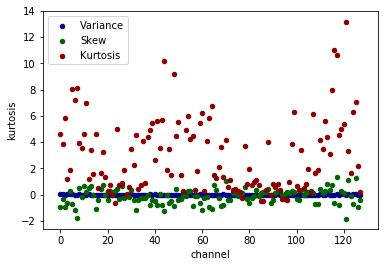

In [61]:
import scipy
arr = [] 
for i in range(0,128):
    temp = []
    var = np.mean(patterns[i])
    skew = scipy.stats.skew(patterns[i])
    kurtosis = scipy.stats.kurtosis(patterns[i])
    temp.append(i)
    temp.append(var)
    temp.append(skew)
    temp.append(kurtosis)
    arr.append(temp)

w = np.array(arr)   
df = pd.DataFrame(w)  
#df
df.columns = ['channel','variance','skew','kurtosis']
ax = df.plot.scatter(x='channel',y='variance',color='DarkBlue',label='Variance')
df.plot.scatter(x='channel',y='skew',color='DarkGreen',label="Skew",ax=ax)
df.plot.scatter(x='channel',y='kurtosis',color="DarkRed",label="Kurtosis",ax=ax)


In [62]:
totalScores = []
XX_train,XX_test,yy_train,yy_test = train_test_split(features_data,target_V_vs_A,test_size=0.20)
time_decod.fit(XX_train,yy_train)
np.mean(time_decod.score(XX_test,yy_test))



0.5662139917695472